In [1]:
import numpy as np
import torch
import json
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import TuSimple
import cv2
import sys
sys.path.append('/home/ksitu/ECE_285/DCNv2/build/lib.linux-x86_64-3.7')
sys.path.append('/home/ksitu/ECE_285/DCNv2/')

In [2]:
from DCNv2 import dcn_v2
from dcn_v2 import DCN
from pose_dla_dcn import get_pose_net

In [3]:
#Not sure if normalization is needed for segmentation but I included it just in case
img_transform = transforms.Compose([
  transforms.Resize((768, 1280)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

#directory of dataset
root_dir = './Data'
batch_size = 3
#initializing dataset and dataloader objects
trainSet = TuSimple.Tusimple(path=root_dir, image_set='train', 
                             img_transforms=img_transform)
valSet = TuSimple.Tusimple(path=root_dir, image_set='val', 
                           img_transforms=img_transform)
testSet = TuSimple.Tusimple(path=root_dir, image_set='test', 
                           img_transforms=img_transform)
trainLoader = DataLoader(trainSet, batch_size=batch_size, shuffle=True, num_workers=4)
ValLoader = DataLoader(valSet, batch_size=batch_size, shuffle=True, num_workers=4)
testLoader = DataLoader(testSet, batch_size=batch_size, shuffle=True, num_workers=4)

In [4]:
#defining initial parameters and model
lr = 1e-4 
num_epochs = 30
weights = torch.tensor([9.6])
heads = {'hm': 1, 'emb': 4}
model = get_pose_net(num_layers=34, heads=heads, head_conv=256, down_ratio=4)
#model = torch.load('parallel_model_earlyStop=loss')
#optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = .005)
use_gpu = torch.cuda.is_available()
cpu_device = torch.device("cpu")
#checking if GPU is available for use
if use_gpu:
    device = torch.device("cuda:0")
    model = model.to(device)
    weights = weights.to(device)
    
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
del weights

In [5]:
def train(batch_size, check_num = 5):
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = .003)
    counter = 0 
    #initializing containers to store accuracy and loss every epoch
    losses = []
    accuracies = []
    FP = []
    FN = []
    val_losses = []
    val_accuracies = []
    val_FP = []
    val_FN = []
    sigmoid = nn.Sigmoid()
    for epoch in range(num_epochs):
        if epoch == 3:
            optimizer = optim.Adam(model.parameters(), lr = 5e-5, weight_decay = .003) 
        elif epoch == 7:
            optimizer = optim.Adam(model.parameters(), lr = 1e-6, weight_decay = .003) 
        elif epoch == 11:
            optimizer = optim.Adam(model.parameters(), lr = 5e-7, weight_decay = .003)
        elif epoch == 16:
            optimizer = optim.Adam(model.parameters(), lr = 1e-7, weight_decay = .003)
            
        ts = time.time()
        #variables to sum loss and accuracy of each batch
        rolling_loss = 0
        rolling_acc = 0
        rolling_FP = 0
        rolling_FN = 0
        for iter, sample in enumerate(trainLoader):
            optimizer.zero_grad()
            if use_gpu:
                inputs = sample['img'].to(device)# Move your inputs onto the gpu
                labels = sample['binary_mask'].to(device,dtype=torch.int)# Move your labels onto the gpu
                segLabel = sample['segLabel'].to(device,dtype=torch.int)
                
            else:
                inputs, labels, segLabel = (sample['img'], sample['binary_mask'], sample['segLabel']) # Unpack variables into inputs and labels

            #print(torch.unique(segLabel))
            detector_ops = model(inputs)[-1]
            outputs = detector_ops['hm']
            emb_outputs = detector_ops['emb']
            #print(outputs.shape)
            del inputs
            torch.cuda.empty_cache()
            loss = criterion(outputs, labels.type_as(outputs))
            outputs = sigmoid(outputs)
            output_cpu = outputs.to(cpu_device).detach().numpy()
            labels_cpu = labels.to(cpu_device).detach().numpy()
            segLabel_cpu = segLabel.to(cpu_device).detach().numpy()
            del outputs
            Acc, false_neg, false_pos = Accuracy(output_cpu, labels_cpu)
            comp_matrix = torch.from_numpy(Comparison(output_cpu, segLabel_cpu))
            comp_matrix = comp_matrix.to(device)
            mean = MeanValue(emb_outputs, comp_matrix)
            var_loss = VarLoss(emb_outputs, comp_matrix, mean)
            dist_loss = Distloss(mean)
            rolling_acc += Acc
            loss += var_loss + dist_loss
            rolling_FP += false_pos
            rolling_FN += false_neg
            del labels,emb_outputs, comp_matrix, mean, var_loss, dist_loss
            torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}, acc: {}, FP: {}, FN: {}".format(epoch, iter, loss.item(), Acc, false_pos, false_neg))

            rolling_loss += loss.item()
            del loss
            torch.cuda.empty_cache()

        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        Normalizing_Factor = len(trainLoader) * batch_size
        losses.append(rolling_loss / Normalizing_Factor)
        accuracies.append(rolling_acc / Normalizing_Factor)
        FP.append(rolling_FP / Normalizing_Factor)
        FN.append(rolling_FN / Normalizing_Factor)
        loss_val, acc_val, Fn_val, Fp_val = Val(epoch, batch_size)
        val_losses.append(loss_val)
        val_accuracies.append(acc_val)
        val_FP.append(Fp_val)
        val_FN.append(Fn_val)
        model.train()
        #Checking if current model is better than the previous best model
        if epoch == 0:
            torch.save(model, 'parallel_model_final_decay=.003')
        else:
            if torch.argmin(torch.Tensor(val_losses)) == epoch:
                print("current-model saved as best model")
                torch.save(model, 'parallel_model_final_decay=.003')
                

        '''if counter == check_num:
            print("early stop achieved")
            torch.save(losses, "parallel_model_earlyStop=loss_rev2_train_loss")
            torch.save(accuracies, "parallel_model_earlyStop=loss_rev2_train_acc")
            torch.save(val_losses, "parallel_model_earlyStop=loss_rev2_val_loss")
            torch.save(val_accuracies, "parallel_model_earlyStop=loss_rev2_val_acc")
            break'''
        
        if epoch == (num_epochs - 1):
            print("training is finished")
            #torch.save(model, 'parallel_model')
            torch.save(losses, "parallel_model_final_decay=.003_train_loss")
            torch.save(accuracies, "parallel_model_final_decay=.003_train_acc")
            torch.save(FP, "parallel_model_final_decay=.003_train_FP")
            torch.save(FN, "parallel_model_final_decay=.003_train_FN")
            torch.save(val_losses, "parallel_model_final_decay=.003_val_loss")
            torch.save(val_accuracies, "parallel_model_final_decay=.003_val_acc")
            torch.save(val_FP, "parallel_model_final_decay=.003_val_FP")
            torch.save(val_FN, "parallel_model_final_decay=.003_val_FN")


def Val(epoch, batchSize):
    model.eval()
    ts = time.time()
    rolling_loss = 0
    rolling_acc = 0
    rolling_FP = 0
    rolling_FN = 0
    sigmoid = nn.Sigmoid()
    for iter, sample in enumerate(ValLoader):
        if use_gpu:
            inputs = sample['img'].to(device)# Move your inputs onto the gpu
            labels = sample['binary_mask'].to(device,dtype=torch.int)# Move your labels onto the gpu
            segLabel = sample['segLabel'].to(device,dtype=torch.int)
            
        else:
            inputs, labels, segLabel = (sample['img'], sample['binary_mask'], sample['segLabel'])# Unpack variables into inputs and labels
            
        detector_ops = model(inputs)[-1]
        outputs = detector_ops['hm']
        emb_outputs = detector_ops['emb']
        #print(outputs.shape)
        del inputs
        torch.cuda.empty_cache()
        loss = criterion(outputs, labels.type_as(outputs))
        outputs = sigmoid(outputs)
        output_cpu = outputs.to(cpu_device).detach().numpy()
        labels_cpu = labels.to(cpu_device).detach().numpy()
        segLabel_cpu = segLabel.to(cpu_device).detach().numpy()
        del outputs
        Acc, false_neg, false_pos = Accuracy(output_cpu, labels_cpu)
        comp_matrix = torch.from_numpy(Comparison(output_cpu, segLabel_cpu))
        comp_matrix = comp_matrix.to(device)
        mean = MeanValue(emb_outputs, comp_matrix)
        var_loss = VarLoss(emb_outputs, comp_matrix, mean)
        dist_loss = Distloss(mean)
        rolling_acc += Acc
        rolling_FP += false_pos
        rolling_FN += false_neg
        loss += var_loss + dist_loss
        del labels,emb_outputs, comp_matrix, mean, var_loss, dist_loss

        if iter% 10 == 0:
            print("epoch{}, iter{}, loss: {}, acc: {}, FP: {}, FN: {}".format(epoch, iter, loss.item(), Acc, false_pos, false_neg))
        
        rolling_loss += loss.item()
        del loss
        torch.cuda.empty_cache()

    print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
    Normalizing_Factor = len(ValLoader) * batch_size
    rolling_acc /= Normalizing_Factor
    rolling_loss /= Normalizing_Factor
    rolling_FP /= Normalizing_Factor
    rolling_FN /= Normalizing_Factor
    return rolling_loss, rolling_acc, rolling_FN, rolling_FP


def Accuracy(output, label):
    output[output >= .6] = 1
    output[output < .6] = 0
    trueLabelIndeces = np.where(label == 1.0)
    falseLabelIndeces = np.where(label == 0.0)
    trueLabels = label[trueLabelIndeces]
    newTrueOutputs = output[trueLabelIndeces]
    falseLabels = label[falseLabelIndeces]
    newFalseOutputs = output[falseLabelIndeces]
    newTrueOutputs = np.reshape(newTrueOutputs, (-1))
    trueLabels = np.reshape(trueLabels, (-1))
    falseLabels = np.reshape(falseLabels, (-1))
    newFalseOutputs = np.reshape(newFalseOutputs, (-1))
    num_false_positives = sum((newFalseOutputs != falseLabels).astype(np.float))
    num_true_positives = sum((newTrueOutputs == trueLabels).astype(np.float))
    acc = float(num_true_positives / trueLabels.shape[0])
    FN = 1 - acc
    FP = float(num_false_positives / falseLabels.shape[0])
    return acc, FN, FP


def Comparison(output, segLabel):
    output[output >= .6] = 1
    output[output < .6] = 0
    #print(np.unique(segLabel))
    comparison_matrix = np.multiply(output, segLabel)
    #print(np.unique(comparison_matrix))
    return comparison_matrix


def MeanValue(emb_output, Label):
    Means = []
    classes = torch.unique(Label)
    for i in range(1, classes.shape[0]):
        indeces = torch.where(Label == i)
        #n x 4 matrix
        pixels = emb_output[indeces[0], :, indeces[2], indeces[3]]
        mean_pixels = torch.mean(pixels, 0)
        #print(mean_pixels)
        Means.append(mean_pixels)

    return Means

def VarLoss(emb_output, Label, means):
    num_classes = len(means)
    if num_classes == 0:
        return 0
    
    delta_v = .5
    loss = 0
    for i in range(num_classes):
        indeces = torch.where(Label == (i + 1))
        pixels = emb_output[indeces[0], :, indeces[2], indeces[3]]
        #print("num of rows: ", rows)
        mean = means[i]
        normalized_pixels = mean - pixels
        #print("before shape: ", normalized_pixels.shape)
        norm_pixels = torch.norm(normalized_pixels, p = 2, dim = 1)
        #print("after shape: ", norm_pixels.shape)
        norm_delta_pixels = norm_pixels - delta_v
        summed_pixels = F.relu(norm_delta_pixels)
        summed_pixels = summed_pixels ** 2
        summed_pixels = torch.mean(summed_pixels)
        #print("summed value ", summed_pixels)
        #print(torch.sum(summed_pixels))
        loss += summed_pixels
               
    return loss / num_classes
    
    
def Distloss(mean):
    num_classes = len(mean)
    if  num_classes <= 1:
        return 0
    
    loss = 0
    delta_d = 3
    for i in range(len(mean)):
        for j in range(len(mean)):
            if i == j:
                continue
            mean1 = mean[i]
            mean2 = mean[j]
            mean_difference = mean1 - mean2
            norm_mean_diff = torch.norm(mean_difference, p = 2)
            delta_minus_mean = delta_d - norm_mean_diff
            delta_minus_mean_relu = F.relu(delta_minus_mean)
            loss += delta_minus_mean_relu ** 2            
    
    return loss / num_classes / (num_classes - 1)
    
    
train(batch_size)

In [5]:
it = iter(testLoader)
first = next(it)

(720, 1280, 3)


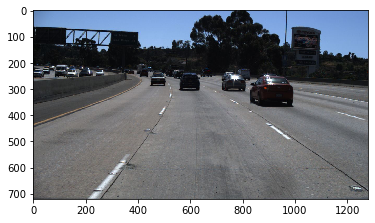

In [6]:
heatmap = first['segLabel']
img = first['img_name']
import glob
import matplotlib.image as mpimg
image = []
for i in range(len(img)):
    for img_path in glob.glob(img[i]):
        image.append(mpimg.imread(img_path))

gray_img = cv2.cvtColor(image[0], cv2.COLOR_BGR2GRAY)
plt.imshow(image[0])
print(image[0].shape)

[0 1 2 3 4]
./Data/clips/0530/1492638333082259606_0/20.jpg


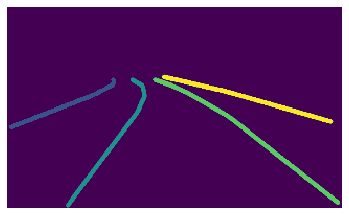

In [7]:
plt.axis('off')
plt.imshow(heatmap.numpy()[0, 0, :, :])
print(np.unique(heatmap.numpy()))
print(first['img_name'][0])

[0. 1.]


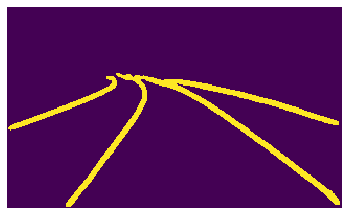

In [12]:
model = torch.load('parallel_model_final')
testImage = first['img'].to(device)
detector_ops = model(testImage)[-1]
outputs = detector_ops['hm']
sigmoid = nn.Sigmoid()
outputs = sigmoid(outputs)
outputs_cpu = outputs.to(cpu_device).detach().numpy()
del outputs
#outputs_cpu[outputs_cpu >= .8] = 1
#outputs_cpu[outputs_cpu < .8] = 0
print(np.unique(outputs_cpu))
plt.axis('off')
plt.imshow(outputs_cpu[0, 0, :, :])

(-0.5, 319.5, 191.5, -0.5)

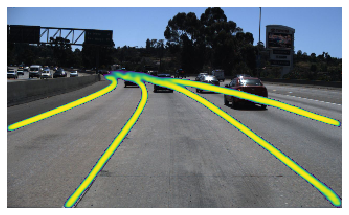

In [11]:
new_image = cv2.resize(image[0], (320, 192))
masked = np.ma.masked_where(outputs_cpu[0, 0, :, :] <= 0.4, outputs_cpu[0, 0, :, :])
plt.imshow(new_image, 'gray')
plt.imshow(masked)
plt.axis('off')

In [11]:
train_losses = torch.load("parallel_model_final_decay=.003_train_loss")
val_losses = torch.load("parallel_model_final_decay=.003_val_loss")

In [12]:
Epoch = [i for i in range(1,31)]

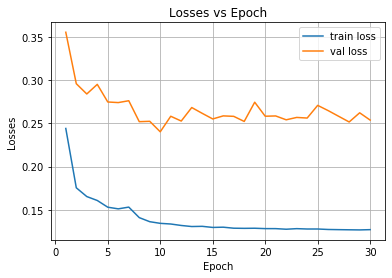

In [13]:
plt.title("Losses vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.grid(which='major', axis='both')
line1 = plt.plot(Epoch, train_losses, label = 'train loss')
line2 = plt.plot(Epoch, val_losses, label = 'val loss')
plt.legend(loc = 'upper right')
plt.show()

In [14]:
train_acc = torch.load("parallel_model_final_decay=.003_train_acc")
val_acc = torch.load("parallel_model_final_decay=.003_val_acc")

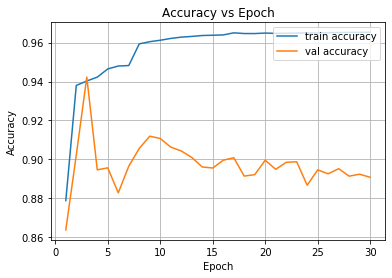

In [15]:
train_acc = [element * 3 for element in train_acc]
val_acc = [element * 3 for element in val_acc]
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(which='major', axis='both')
line1 = plt.plot(Epoch, train_acc, label = 'train accuracy')
line2 = plt.plot(Epoch, val_acc, label = 'val accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [16]:
train_FP = torch.load("parallel_model_final_decay=.003_train_FP")
val_FP = torch.load("parallel_model_final_decay=.003_val_FP")

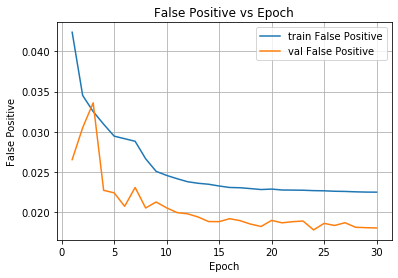

In [17]:
train_FP = [element * 3 for element in train_FP]
val_FP = [element * 3 for element in val_FP]
plt.title("False Positive vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("False Positive")
plt.grid(which='major', axis='both')
line1 = plt.plot(Epoch, train_FP, label = 'train False Positive')
line2 = plt.plot(Epoch, val_FP, label = 'val False Positive')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
model = torch.load('parallel_model_final')
testImage = first['img'].to(device)
detector_ops = model(testImage)[-1]
outputs = detector_ops['hm']
sigmoid = nn.Sigmoid()
outputs = sigmoid(outputs)
outputs_cpu = outputs.to(cpu_device).detach().numpy()
del outputs
outputs_cpu[outputs_cpu >= .8] = 1
outputs_cpu[outputs_cpu < .8] = 0
print(np.unique(outputs_cpu))
plt.axis('off')
plt.imshow(outputs_cpu[0, 0, :, :])

In [13]:
embed = detector_ops['emb']
embed_cpu = embed.to(cpu_device).detach().numpy()
print(embed_cpu.shape)

(3, 4, 192, 320)


In [15]:
from kmeans_pytorch import kmeans
#from torchcluster.zoo.spectrum import SpectrumClustering

def Cluster(embed, Label):
    outputs_gpu = torch.from_numpy(Label)
    indices = torch.where(outputs_gpu == 1)
    num_clusters = 4
    shape = Label.shape
    new_outputs = torch.zeros(shape[0], shape[1], shape[2], shape[3])
    cluster_ids_x, cluster_centers = kmeans(embed[indices[0], :, indices[2], indices[3]], 
                                            num_clusters=num_clusters, 
                                            distance='euclidean', 
                                            device=torch.device('cuda:0'))
    
    for i in range(len(cluster_ids_x)):
        laneval = cluster_ids_x[i]
        new_outputs[indices[0][i], :, indices[2][i], indices[3][i]] = laneval + 1

    output = new_outputs
    return output

[running kmeans]: 6it [00:00, 58.94it/s, center_shift=0.000022, iteration=6, tol=0.000100]

[0. 1.]
running k-means on cuda:0..


[0. 1. 2. 3. 4.]


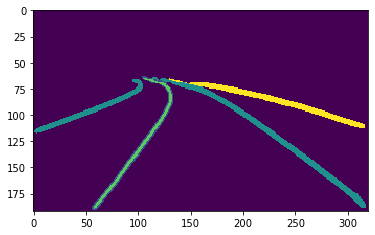

In [16]:
print(np.unique(outputs_cpu))
new_output = Cluster(embed,outputs_cpu)
new_output = new_output.to(cpu_device).detach().numpy()
cluster_img = new_output[0, 0, :, :]
plt.imshow(cluster_img, interpolation='none', vmin=0, vmax=4)
print(np.unique(cluster_img))
#print(new_output[0, 0, 175, 50])

(-0.5, 319.5, 191.5, -0.5)

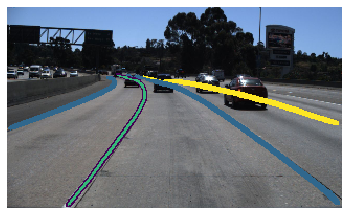

In [17]:
masked = np.ma.masked_where(new_output[0, 0, :, :] <= 0.4, new_output[0, 0, :, :])
plt.imshow(new_image, 'gray')
plt.imshow(masked)
plt.axis('off')

In [10]:
def Test(batchSize):
    model = torch.load('parallel_model_final')
    model.eval()
    ts = time.time()
    rolling_loss = 0
    rolling_acc = 0
    rolling_FP = 0
    rolling_FN = 0
    sigmoid = nn.Sigmoid()
    test_losses = []
    test_accuracies = []
    test_FP = []
    test_FN = []
    for iter, sample in enumerate(testLoader):
        if use_gpu:
            inputs = sample['img'].to(device)# Move your inputs onto the gpu
            labels = sample['binary_mask'].to(device,dtype=torch.int)# Move your labels onto the gpu
            segLabel = sample['segLabel'].to(device,dtype=torch.int)
            
        else:
            inputs, labels, segLabel = (sample['img'], sample['binary_mask'], sample['segLabel'])# Unpack variables into inputs and labels
            
        detector_ops = model(inputs)[-1]
        outputs = detector_ops['hm']
        embed = detector_ops['emb']
        #print(outputs.shape)
        del inputs
        torch.cuda.empty_cache()
        loss = criterion(outputs, labels.type_as(outputs))
        outputs = sigmoid(outputs)
        output_cpu = outputs.to(cpu_device).detach().numpy()
        labels_cpu = labels.to(cpu_device).detach().numpy()
        segLabel_cpu = segLabel.to(cpu_device).detach().numpy()
        del outputs
        Acc, false_neg, false_pos = Accuracy(output_cpu, labels_cpu)
        mask = Comparison(output_cpu, segLabel_cpu)
        comp_matrix = torch.from_numpy(mask)
        comp_matrix = comp_matrix.to(device)
        mean = MeanValue(embed, comp_matrix)
        var_loss = VarLoss(embed, comp_matrix, mean)
        dist_loss = Distloss(mean)
        rolling_acc += Acc
        rolling_FP += false_pos
        rolling_FN += false_neg
        loss += var_loss + dist_loss
        del labels,embed, comp_matrix, mean, var_loss, dist_loss

        if iter% 10 == 0:
            print("iter{}, loss: {}, acc: {}, FP: {}, FN: {}".format(iter, loss.item(), Acc, false_pos, false_neg))
        
        rolling_loss += loss.item()
        del loss
        torch.cuda.empty_cache()

    print("time elapsed {}".format(time.time() - ts))
    Normalizing_Factor = len(testLoader) * batch_size
    rolling_acc /= Normalizing_Factor
    rolling_loss /= Normalizing_Factor
    rolling_FP /= Normalizing_Factor
    rolling_FN /= Normalizing_Factor
    return rolling_loss, rolling_acc, rolling_FN, rolling_FP


torch.cuda.empty_cache()
test_loss, test_acc, test_FN, test_FP = Test(3)
print("test_loss: ", test_loss)
print("test_acc: ", test_acc * 3)
print("test_FN: ", test_FN * 3)
print("test_FP", test_FP * 3)

iter0, loss: 0.5425651669502258, acc: 0.9611355700622438, FP: 0.01802141414368744, FN: 0.038864429937756184
iter10, loss: 0.7144086956977844, acc: 0.8164424514200299, FP: 0.01817260597871981, FN: 0.1835575485799701
iter20, loss: 0.4814488887786865, acc: 0.9859592277575266, FP: 0.017211849892319955, FN: 0.014040772242473354
iter30, loss: 0.5423469543457031, acc: 0.9574788077659283, FP: 0.0217450255923528, FN: 0.04252119223407169
iter40, loss: 0.5023496150970459, acc: 0.9325826882477128, FP: 0.02216516660553565, FN: 0.06741731175228716
iter50, loss: 0.5231586694717407, acc: 0.9416678465241399, FP: 0.021076741680159317, FN: 0.05833215347586007
iter60, loss: 0.6230063438415527, acc: 0.8459808215934651, FP: 0.02334639199877184, FN: 0.1540191784065349
iter70, loss: 1.0951181650161743, acc: 0.9892565535023635, FP: 0.017153587197401586, FN: 0.010743446497636477
iter80, loss: 0.4780508279800415, acc: 0.9684743124026985, FP: 0.017009036758544153, FN: 0.031525687597301455
iter90, loss: 0.42385286